## Quick record section plot

Quick view of waveforms for an earthquake.
Enter all event parameters in single cell.  Waveforms are then downloaded from datacenter and plotted as record section.

Richard Allen - March 2020

In [ ]:
## in datahub, need to install packages. 
## Need to let support know that the package is needed (if not already on system - try first), 
## they make is available in the system and then you can install with the following command 
## at the top of your notebook

!pip install obspy

In [1]:
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.geodetics import gps2dist_azimuth

### All parameters defined in this cell...


In [2]:
## Napa M6.0 - 2014-08-24 10:20:44.070
## https://earthquake.usgs.gov/earthquakes/eventpage/nc72282711/executive
t0 = UTCDateTime('2014-08-24T10:20:44.070')   ## origin time
t1 = UTCDateTime('2014-08-24T10:24:44.070')   ## end time for waveforms
evla = 38.215
evlo = -122.312

Xkm = 400   ## MAX distance of stations to download
minplotmeters = 0  ## min and max dist for record section (in METERS)
maxplotmeters = 400000

channel = 'BHE'

network = 'BK'
client = Client('NCEDC')
#client = Client('IRIS')   ## includes SCSN data

removeresponse = True  

### Obtain wavefrom data and plot record section


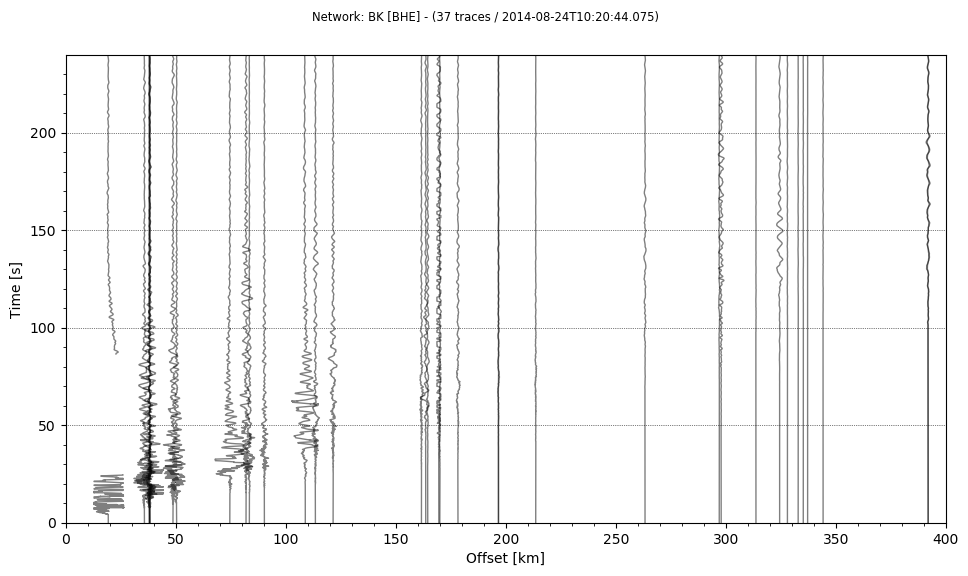

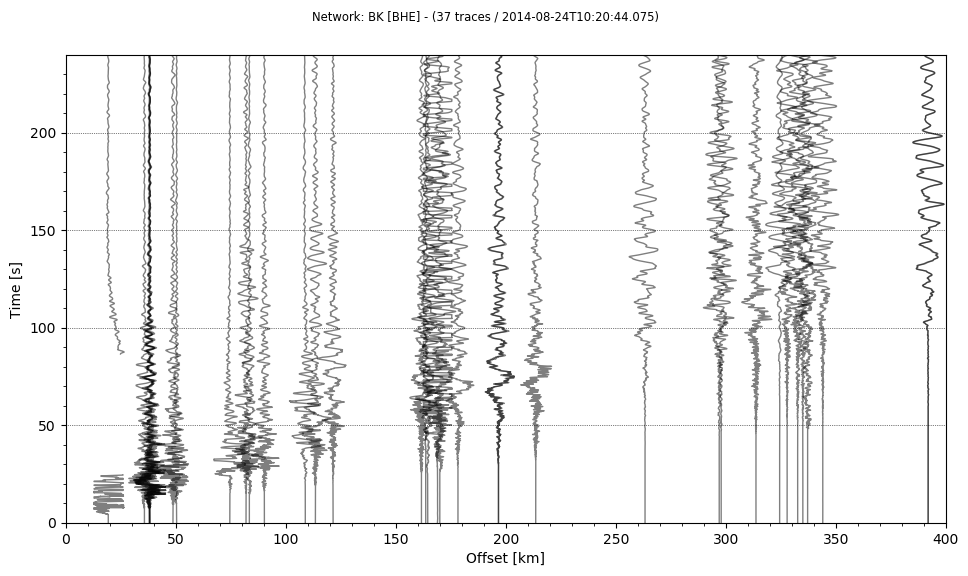

In [4]:
print_sta_dist_list = False

## get list of stations with metadata
stations = client.get_stations(network = network, starttime=t0, endtime=t1)
#print(stations)

stations_withinXkm = []
for station in stations[0]:
    station_info = station
    stla = station_info.latitude
    stlo = station_info.longitude
    stnm = station_info.code
    
    dist = gps2dist_azimuth(stla, stlo, evla, evlo)[0]/1000.
    
    if dist < Xkm:
        stations_withinXkm.append(stnm)   
        if print_sta_dist_list:
            print(stnm,' is ',dist,' km from epicenter')
        
stations_withinXkm = ','.join(stations_withinXkm)  ## need comma separated list

## request waveforms 
st = client.get_waveforms(network = network, \
                          station = stations_withinXkm, \
                          location = '*', channel=channel, \
                          starttime=t0, endtime=t1, \
                          attach_response = True)

## bandpass filter for use with instrument response removal
bandpass = (0.005, 0.006, 18.0, 20.0)

## removing response is easy
if removeresponse:
    st.remove_response(output='VEL', pre_filt=bandpass)   

## plot individual wavefroms    
#st.plot(projection="local")

## calc and store epicentral distance for each waveform
for tr in st:
    stnm = tr.stats.station
    station_info = stations.select(station = stnm)[0][0]
    stla = station_info.latitude
    stlo = station_info.longitude
    dist = gps2dist_azimuth(evla, evlo, stla, stlo)[0]
    # need to define this distance in m
    tr.stats.distance = dist

## offset_max is max dist of traces to plot.  400000 = 400 km
st.plot(type='section', norm_method='stream', 
        offset_min = minplotmeters, offset_max = maxplotmeters)
st.plot(type='section', norm_method='trace', 
        offset_min = minplotmeters, offset_max = maxplotmeters)

plt.show()

### Now get and plot single waveform - showing absolute amplitudes

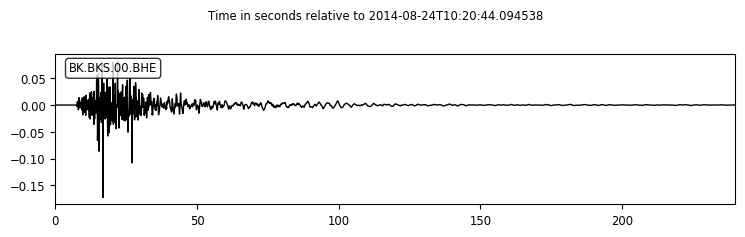

In [5]:
## just just the waveform requires
st = client.get_waveforms(station = 'BKS', \
                          network = network, location = '*', channel=channel, \
                          starttime=t0, endtime=t1, attach_response = True)

## bandpass filter for use with instrument response removal - output in ACC in m/s2, VEL in m/s, DIS in m
bandpass = (0.005, 0.006, 18.0, 20.0)
st.remove_response(output='ACC', pre_filt=bandpass) 

## and plot
st.plot(type = 'relative')

plt.show()